# Model Application

Finally, time to actually solve our problem!

Our problem statement: Recommend restaurants which are in some important way *different*, but otherwise *similar* to the restaurants a user has already been to, such that by following our recommendation system users will end up having novel experiences which are nevertheless somewhat familiar to them.

How do we find restaurants which are "different in an important way"? That is what our clustering did, and we ended up with some very clearly distinct clusters with large gaps between them, as shown by the UMAP visualisation and the high CV F1 score of the classifier.

How do we quantify being *otherwise similar*? Just the normal K-Prototypes distance metric, but constrained by the previous step of restricting ourselves to the furthest-away cluster.

There is one kink in this, and that is that as a user's history grows it will become harder for any new history items (that is to say, restaurants) to have a signficant effect on their aggregate distances to restaurants in the data set. The solution we choose is to apply some kind of scaling factor, let's say 0.75, such that each history item's contribution to distance is 0.75 of the next history item's contribution, such that by the eight history item its contribution is reduced to (0.75)^7 ~ 1/10th of what it would otherwise be. With this in mind, we'll cap the length of history at 10 history items.

Our proposed procedure, then, will be to find the "important difference" (far-away clusters), and then finding the "otherwise similar" points to recommend (close points within the cluster). In the case of the user providing multiple points, we will sum the distance from each point scaled according to the age of the user's history items, with the history capped at a certain length.  

## Initialising libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from kmodes.kprototypes import KPrototypes
import pickle

## Importing dataset and models

In [3]:
#Initialise dataset
restaurant_data = pd.read_csv('../Data/cleaned_onehotted.csv').iloc[: , 1:]
cuisines = pd.read_csv('../Data/cuisines.csv')
restaurant_data.head(2)

,name,rating,latitude,longitude,price,cuisine_cats,mult_cuisines,Asian Variety,Multi-Cuisine,Korean,...,Western Variety,Vietnamese,Beijing,Russian,Foochow,Hakka,Caribbean,Filipino,Irish,Dong Bei
0,1-V:U,3.5,1.252299,103.820211,40.5,[0],0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10 At Claymore,4.0,1.307401,103.829904,65.5,[1],0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
with open('..\Data\models.pickle', 'rb') as handle:
    models = pickle.load(handle)
with open('..\Data\df_K_clusters.pickle', 'rb') as handle:
    df_K_clusters = pickle.load(handle)

In [18]:
kprototype = models[10]

In [391]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(restaurant_data[['latitude', 'longitude', 'price']])
restaurant_data[['latitude', 'longitude', 'price']] = scaler.transform(restaurant_data[['latitude', 'longitude', 'price']])

## Processing user input

For the sake of completeness, first we'll make a function to input a user's past restaurants.

In [34]:
def input_restaurant_data():
    num_rows = int(input("How many restaurants have you been to?"))
    rows = []
    for i in range(num_rows):
        print("Restaurant #{}".format(i+1))
        r_data = [0 for i in range(3+len(cuisines))]
        r_data[0] = int(input("Latitude?"))
        r_data[1] = int(input("Longitude?"))
        r_data[2] = int(input("Price?"))
        cuisines_list = list(cuisines.iloc[:,0])
        print("Cuisines understood: {}".format(cuisines_list))
        cuisine_num = int(input("How many cuisines did the restaurant serve?"))
        for j in range(cuisine_num):
            while True:
                cuisine = input("Cuisine #{}:".format(j+1))
                if cuisine in cuisines_list:
                    r_data[3+cuisines_list.index(cuisine)] = 1
                    break
                else:
                    print("Cuisine not recognised, try again")
        rows.append(r_data)
    return pd.DataFrame(rows, columns=['latitude', 'longitude', 'price', *cuisines_list])

Next we make a function to collapse a dataframe of multiple restaurants into one. We won't be doing this for our cluster recomendations, its just for utility. The rule we follow is that for features we treat as numeric in our clustering, like price, latitude, and longitude, we will take the mean. Meanwhile, for our categorical features (our one-hotted cuisines), we will use boolean or.

In [402]:
cuisines_list= list(cuisines.iloc[:,0])
def collapse_restaurants(df):
    df = df[['latitude', 'longitude', 'price'] + cuisines_list]
    averaged = list(df[['latitude', 'longitude', 'price']].apply(lambda x: x.mean()))
    averaged += list(df[cuisines_list].apply('any'))
    new_df = pd.DataFrame([averaged], columns=['latitude', 'longitude', 'price'] + cuisines_list)
    return new_df
example = collapse_restaurants(restaurant_data.iloc[:10,:])

Lastly, for later convenience we make a function which takes a dataframe of restaurants (with unscaled longitude, latitude, and price), and labels it with cluster labels, although we will be computing the far-away clusters from our provided restaurants directly.

In [403]:
def label_restaurants(df):
    df_array = df[['latitude', 'longitude', 'price'] + cuisines_list].to_numpy(dtype=float)
    categorical_index = [i for i in range(3, 3+len(cuisines_list))]
    df.insert(3, 'label', kprototype.predict(df_array, categorical=categorical_index))
    return df

def label_restaurants_no_mut(df):
    df_copy = df.copy()
    df_array = df_copy[['latitude', 'longitude', 'price'] + cuisines_list].to_numpy(dtype=float)
    categorical_index = [i for i in range(3, 3+len(cuisines_list))]
    return kprototype.predict(df_array, categorical=categorical_index)

label_restaurant(example)

,latitude,longitude,price,label,Asian Variety,Multi-Cuisine,Korean,Belgian,Singaporean,Chinese,...,Western Variety,Vietnamese,Beijing,Russian,Foochow,Hakka,Caribbean,Filipino,Irish,Dong Bei
0,0.24614,0.56532,0.040909,0,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


## Computing clusters to recommend

We calculate dissimilarity the same way K-Prototypes does, by finding the numerical dissimilarity (Euclidean distance) and the categorical dissimilarity (number of non-matching categories), then computing `tot_costs = num_costs + gamma * cat_costs`.

We then pick the three most dissimilar clusters as the recommendations for our input points.

Here we compute the clusters to recommend for each row in our dataset, treating it as a row of users, each of whom have one restaurant in their history.

In [494]:
import math
import tqdm.notebook
from numba import jit

history_scaling_factor = 0.75

def sort_idx(lst, rev=True):
    index = range(len(lst))
    s = sorted(index, reverse=rev, key=lambda i: lst[i])
    return s

# for recommendations, takes all rows as belonging to one user 
def find_centroid_assoc_for_all_rows(df, skiptrans=False):
    df = pd.DataFrame(df[['latitude', 'longitude', 'price'] + cuisines_list])

    #the distances to the centroids
    distances = [0 for i in range(len(kprototype.cluster_centroids_))]
    
    for i in range(df.shape[0]):
        #current point
        our_point = df.iloc[[i]].to_numpy()[0]

        for j in range(len(kprototype.cluster_centroids_)):
            centroid = kprototype.cluster_centroids_[j]
            num_dissim = np.sum((our_point[:3]-centroid[:3])**2)
            cat_dissim = np.sum(np.logical_xor(our_point[3:], centroid[3:]))
            dissim = num_dissim + kprototype.gamma * cat_dissim
            distances[j] += dissim * history_scaling_factor ** i

    return sort_idx(distances)[:3]

# for testing, each user has 1 restaurant they've been to
def find_centroid_assocs_for_each_row(df):
    df = pd.DataFrame(df[['latitude', 'longitude', 'price'] + cuisines_list])
    centroid_assocs = []
    
    for i in tqdm.notebook.tqdm(range(df.shape[0])):
        #current point
        our_point = df.iloc[[i]]
        centroid_assocs.append(find_centroid_assoc_for_all_rows(our_point))

    df.insert(3, 'centroid_assocs', centroid_assocs)
    df = label_restaurants(df)
    return df

In [496]:
df = find_centroid_assocs_for_each_row(restaurant_data)
df.head()

  0%|          | 0/2833 [00:00<?, ?it/s]

,latitude,longitude,price,label,centroid_assocs,Asian Variety,Multi-Cuisine,Korean,Belgian,Singaporean,...,Western Variety,Vietnamese,Beijing,Russian,Foochow,Hakka,Caribbean,Filipino,Irish,Dong Bei
0,0.040402,0.452707,0.090909,2,"[9, 1, 11]",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.286747,0.483832,0.154040,2,"[1, 9, 8]",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.170052,0.539025,0.053030,2,"[9, 1, 8]",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.251147,0.556079,0.027778,2,"[1, 8, 9]",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.174796,0.527638,0.000000,1,"[9, 8, 0]",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Plotting the clusters recommended

We will draw a histogram of the clusters recommended by our procedure when we take each row/restaurant of our dataset as the one-element history of a different user, versus those present in our data.

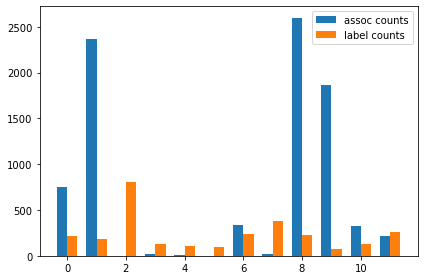

In [497]:
from collections import Counter

counter_assocs = Counter(list(df['centroid_assocs'].explode()))
counter_labels = Counter(list(df['label']))

assoc_counts = []
label_counts = []
for i in range(len(kprototype.cluster_centroids_)):
    if i not in counter_assocs:
        assoc_counts.append(0)
    else:
        assoc_counts.append(counter_assocs[i])
    if i not in counter_labels:
        label_counts.append(0)
    else:
        label_counts.append(counter_labels[i])

fig, ax = plt.subplots()

width = 0.35  # the width of the bars
x = np.arange(len(kprototype.cluster_centroids_))
rects1 = ax.bar(x - width/2, assoc_counts, width, label='assoc counts')
rects2 = ax.bar(x + width/2, label_counts, width, label='label counts')

plt.legend(["assoc counts", "label counts"])

fig.tight_layout()

plt.show()

df1 = pd.DataFrame.copy(df)

There is a strong bias towards four or so clusters which are far from the rest of the clusters, which is to be expected as we are running our cluster recommender procedure with each user corresponding to a single row in our dataset, having only one restaurant in our history, thus it gravitates simply to clusters far away from the rest of the dataset.

Let's try simulating each user taking the centerpoints of one (random choice) of the three clusters we have recommended them and adding them to their history, and see how our distribution of cluster recommendations changes.

In [498]:
import random

centroid_assocs = []
second_choices = []

for i in tqdm.notebook.tqdm(range(df.shape[0])):
    our_point = df.iloc[[i]]

    our_point_transformed = pd.DataFrame(our_point)
    our_point_transformed = our_point_transformed[['latitude', 'longitude', 'price'] + cuisines_list].to_numpy()[0]
        
    other_points = []
        
    for j in random.choices(list(our_point['centroid_assocs'])[0], k=1):
        other_points.append(kprototype.cluster_centroids_[j])
        second_choices.append([j])
    
    points = other_points
    points.append(our_point_transformed)
    
    pointsDF = pd.DataFrame(points, columns = ['latitude', 'longitude', 'price'] + cuisines_list)

    centroid_assocs.append(find_centroid_assoc_for_all_rows(pointsDF, skiptrans=True))
    
df['centroid_assocs'] = centroid_assocs
df.insert(5, 'second_choices', second_choices)

  0%|          | 0/2833 [00:00<?, ?it/s]

In [499]:
df.head()

,latitude,longitude,price,label,centroid_assocs,second_choices,Asian Variety,Multi-Cuisine,Korean,Belgian,...,Western Variety,Vietnamese,Beijing,Russian,Foochow,Hakka,Caribbean,Filipino,Irish,Dong Bei
0,0.040402,0.452707,0.090909,2,"[1, 8, 0]",[11],1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.286747,0.483832,0.154040,2,"[1, 9, 4]",[8],0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.170052,0.539025,0.053030,2,"[8, 9, 0]",[1],0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.251147,0.556079,0.027778,2,"[8, 1, 0]",[9],0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.174796,0.527638,0.000000,1,"[9, 8, 10]",[0],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's plot the distribution of our new recommendations on top of our old chart.

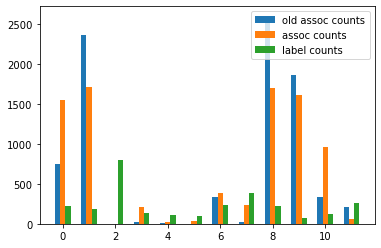

In [500]:
from collections import Counter

counter_old_assocs = Counter(list(df1['centroid_assocs'].explode()))
counter_assocs = Counter(list(df['centroid_assocs'].explode()))
counter_labels = Counter(list(df['label']))

old_assoc_counts = []
assoc_counts = []
label_counts = []
for i in range(len(kprototype.cluster_centroids_)):
    if i not in counter_old_assocs:
        old_assoc_counts.append(0)
    else:
        old_assoc_counts.append(counter_old_assocs[i])
    if i not in counter_assocs:
        assoc_counts.append(0)
    else:
        assoc_counts.append(counter_assocs[i])
    if i not in counter_labels:
        label_counts.append(0)
    else:
        label_counts.append(counter_labels[i])

fig, ax = plt.subplots()

width = 0.20  # the width of the bars
x = np.arange(len(kprototype.cluster_centroids_))
rects1 = ax.bar(x - width, old_assoc_counts, width, label='old assoc counts')
rects2 = ax.bar(x, assoc_counts, width, label='assoc counts')
rects3 = ax.bar(x + width, label_counts, width, label='label counts')

plt.legend(["old assoc counts", "assoc counts", "label counts"])

df2 = pd.DataFrame.copy(df)

As we can see, iterating once and having our customers pick one of our recommendations as their second restaurant  improved our recommendation diversity, bringing it closer to an even spread. Let's try iterating a third time.

In [511]:
import random

centroid_assocs = []

for i in tqdm.notebook.tqdm(range(df.shape[0])):
    our_point = df.iloc[[i]]

    our_point_transformed = pd.DataFrame(our_point)
    our_point_transformed = our_point_transformed[['latitude', 'longitude', 'price'] + cuisines_list].to_numpy()[0]
        
    other_points = []
        
    for j in [i for i in random.choices(list(our_point['centroid_assocs'])[0], k=1)]:
        other_points.append(kprototype.cluster_centroids_[j])
    for j in list(our_point['second_choices'].iloc[0]):
        other_points.append(kprototype.cluster_centroids_[int(j)])
    
    points = other_points
    points.append(our_point_transformed)
    
    pointsDF = pd.DataFrame(points, columns = ['latitude', 'longitude', 'price'] + cuisines_list)

    centroid_assocs.append(find_centroid_assoc_for_all_rows(pointsDF, skiptrans=True))
    
df['centroid_assocs'] = centroid_assocs

  0%|          | 0/2833 [00:00<?, ?it/s]

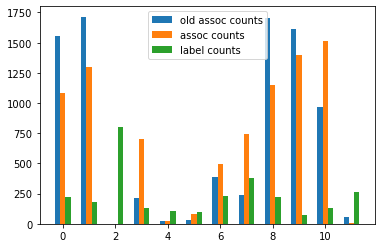

In [512]:
from collections import Counter

counter_old_assocs = Counter(list(df2['centroid_assocs'].explode()))
counter_assocs = Counter(list(df['centroid_assocs'].explode()))
counter_labels = Counter(list(df['label']))

old_assoc_counts = []
assoc_counts = []
label_counts = []
for i in range(len(kprototype.cluster_centroids_)):
    if i not in counter_old_assocs:
        old_assoc_counts.append(0)
    else:
        old_assoc_counts.append(counter_old_assocs[i])
    if i not in counter_assocs:
        assoc_counts.append(0)
    else:
        assoc_counts.append(counter_assocs[i])
    if i not in counter_labels:
        label_counts.append(0)
    else:
        label_counts.append(counter_labels[i])

fig, ax = plt.subplots()

width = 0.20  # the width of the bars
x = np.arange(len(kprototype.cluster_centroids_))
rects1 = ax.bar(x - width, old_assoc_counts, width, label='old assoc counts')
rects2 = ax.bar(x, assoc_counts, width, label='assoc counts')
rects3 = ax.bar(x + width, label_counts, width, label='label counts')

plt.legend(["old assoc counts", "assoc counts", "label counts"])

df3 = pd.DataFrame.copy(df)

Once again, iterating to simulate the users each choosing another restaurant from the list of restaurants (in this case, bringing their history to 3 restaurants) appears to have the effect of increasing the diversity of cluster recommendations. It seems like the robustness of our cluster recommender strongly benefits from our users having multiple restaurants in their histories.

## Computing restaurants within a cluster to recommend.

So far, we've simply been doing the cluster recommendation (the "novelty" step), and then picking the centroid of the cluster as what we recommend. What we should really do is pick the point in the recommended cluster which is "otherwise similar" to the restaurants the user has already been to.

Given a list of restaurants and a cluster label, we want a function which finds the restaurant in the cluster indicated with the closest centroid-relative positon to the input restaurants.

In [513]:
def point_dissim(x, y):
    x = x[['latitude', 'longitude', 'price'] + cuisines_list].to_numpy()
    y = y[['latitude', 'longitude', 'price'] + cuisines_list].to_numpy()
    num_dissim = np.sum((x[:3]-y[:3])**2)
    cat_dissim = np.sum(np.logical_xor(x[3:] == 1, y[3:] == 1))
    return num_dissim + kprototype.gamma * cat_dissim 

def pick_restaurant(input_rows, label):
    df = restaurant_data
    df = df.drop(df[df.label != label].index)
    
    dissims = df.apply(lambda x:
                       input_rows.apply(lambda y:
                                        point_dissim(x, y),
                                        axis=1).sum(),
                       axis=1)
    return restaurant_data.iloc[[int(dissims.idxmin())],:]
pick_restaurant(restaurant_data.iloc[[0, 1],:], 0)

,name,rating,latitude,longitude,price,cuisine_cats,mult_cuisines,Asian Variety,Multi-Cuisine,Korean,...,Vietnamese,Beijing,Russian,Foochow,Hakka,Caribbean,Filipino,Irish,Dong Bei,label
1696,PasarBella,4.0,0.427431,0.365284,0.0,[1],0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Putting it all together

It's now time to write a procedure which takes a list of restaurants and returns recommendations with the most similar restaurants belonging to the 3 farthest clusters. Moment of truth...

In [514]:
def recommend(input_rows):
    labels = find_centroid_assoc_for_all_rows(input_rows)
    recs = []
    for label in labels:
        recs.append(pick_restaurant(input_rows, label))
    return pd.concat(recs)
recommend(restaurant_data.iloc[[0, 1],:])

,name,rating,latitude,longitude,price,cuisine_cats,mult_cuisines,Asian Variety,Multi-Cuisine,Korean,...,Vietnamese,Beijing,Russian,Foochow,Hakka,Caribbean,Filipino,Irish,Dong Bei,label
1554,November8 Coffee &amp; Company,3.5,0.492444,0.502299,0.027778,[16],0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
2831,Whampoa Keng,3.5,0.373403,0.532156,0.053030,[5],0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1281,Majestic Restaurant,4.0,0.161138,0.517414,0.090909,"[6, 7]",1,0,0,0,...,0,0,0,0,0,0,0,0,0,8


Seems succesful! Now time for some methodical exploration/analysis of the characteristics of our recommender system.

## Solution evaluation and conclusion

Now that we've got this nice recommender system built, we want to look at its behaviour. That is to say, does it meet what we want from a recommender system?

Firstly, we want our recommender system to provide **varied recommendations** to all of our users, that is to say, our different users should not all get recommended the same things.

Now, we've already seen that the variance in *diversity of recommended clusters*, that is, the clusters the restaurants recommended come from changes in an interesting manner as users use our recommender system. Here, we'll run it for more iterations automatically, let's say seven iterations.

We will also look at the **coverage** of our recommender system, that is to say, what proportion of our restaurants get recommended?

Lastly, we will look at the **freshness** of recommendations, that is to say, do the recommendations eventually get stuck in a loop, or do we keep recommending new things?

### Varied recommendations

### Coverage

### Freshness

### Conclusion